## Week 7 - Tips and tricks for projects
* Get data from APIs
* Turn x,y coordinate data into geometry
* Create a bounding box for data downloads
* Calculate means and regressions with sample weights

In [211]:
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import pylab as plt
%pylab inline
import mplleaflet as mpll
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


/Users/nicholasjones/anaconda3/envs/GPD/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'plt', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 1. Getting data from APIs

#### What are APIs, why use them?

Companies and organizations make certain data available through their Application Programming Interfaces (APIs). To use an API, you make a request to a remote web server via its HTTP address, and retrieve the data you need.

You can retrieve data from APIs instead of downloading a static file to your hard drive and reading it in. This is helpful where:
* you want the latest data in real time (eg. stock prices or weather)
* you want a small, selected piece of data (eg. hospital locations in north Wales)
* the organization will run its own computations for you (eg. request satellite imagery with cloud cover removed, Planet API; analyze sentiment of a document, IBM Watson API).


|Example API|Functionality|
|---|---|
|Socrata|Retrieve city open data|
|Overpass API|Get OpenStreetMap data|
|Google Maps|Get point of interest locations, create distance features|
|Yahoo Stock|Get stock prices|
|Twitter, Youtube, Instagram|Get social media data|
|World Bank Indicators API|Get data from WDI, Doing Business etc|

#### Four steps to using APIs

1. Read the documentation

  APIs are rules specifying what query you should send, and what format of data the server will return back. You query APIs using an HTTP request (ie. a web address). Read the docs to check (i) what the API can do; (ii) what the HTTP request should look like. 

2. Find the API endpoint

  Examples: http://api.twitter.com, http://api.github.com


3. Try a sample query in your web brower or terminal: `curl <http://...>`

  Queries start with the API endpoint, then add commands using the API's specific format. Send a sample query to see what the output looks like. Normally it will be Javascript Object Notation (JSON) format).


4. Extract the information you need from the JSON.

  Remember JSON is a widely used data interchange format. It gives you nested dictionaries and lists (weeks 2-3).


5. Write some code to send custom requests.

  The `requests` library is a painless way to make HTML requests. Using the API's rules and some lines of code, you can quickly request the precise data you want. There are also API wrappers (small Python libraries that manage API requests for you, providing an easier syntax).

### Worked example 1: How many humans in space?
    
A simple API, created by space travel enthusiasts, is [Open Notify](http://open-notify.org/).


YOUR ACTION:
* Check the website to figure out what's going on: http://open-notify.org/
* Can you find the endpoint we need, as an `http://` address?
* Then run the code below, and complete the exercise.

In [121]:
endpoint_url = 'http://api.open-notify.org/astros.json'

In [122]:
response = requests.get(endpoint_url2)

In [123]:
response.status_code

200

In [129]:
data = response.json()
data

{'message': 'success',
 'number': 6,
 'people': [{'craft': 'ISS', 'name': 'Oleg Kononenko'},
  {'craft': 'ISS', 'name': 'David Saint-Jacques'},
  {'craft': 'ISS', 'name': 'Anne McClain'},
  {'craft': 'ISS', 'name': 'Alexey Ovchinin'},
  {'craft': 'ISS', 'name': 'Nick Hague'},
  {'craft': 'ISS', 'name': 'Christina Koch'}]}

#### EXERCISE:
* Print a statement like this: "There are currently <x number> people in space."
* Then print their names, in alphabetical order. Bonus: print it as a Pandas dataframe (sorted alphabetically).

## Worked example 2: Mexico open data

**Objective: ** Get data from a national Open Data Portal, convert lat / lon coordinates into a geometry object, plot a map of temperatures in Mexico.

Steps below:
* Look at the Government of Mexico open data portal: https://datos.gob.mx/.
* Inspect the Condiciones Atmosfericas link in your web browser or via `curl <url>`.
* Make a basic API request and process the data.

In [131]:
endpoint_url = 'https://api.datos.gob.mx/v1/condiciones-atmosfericas'

In [132]:
response = requests.get(endpoint_url)

In [134]:
data = response.json()

In [135]:
data['results']

[{'_id': '5952983359954a0adbf7ab09',
  'cityid': 'MXAS0002',
  'validdateutc': '20170627T140000Z',
  'winddirectioncardinal': 'SSE',
  'probabilityofprecip': '40',
  'relativehumidity': '90',
  'name': 'Aguascalientes',
  'date-insert': '2017-06-27T17:36:43.084Z',
  'longitude': '-102.296',
  'state': 'Aguascalientes',
  'lastreporttime': '20170627T092449Z',
  'skydescriptionlong': 'Tormentas dispersas',
  'stateabbr': 'AGU',
  'tempc': '17',
  'latitude': '21.87982',
  'iconcode': '96',
  'windspeedkm': '6'},
 {'_id': '5952983359954a0adbf7ab0a',
  'cityid': 'MXAS0170',
  'validdateutc': '20170627T140000Z',
  'winddirectioncardinal': 'S',
  'probabilityofprecip': '60',
  'relativehumidity': '91',
  'name': 'Asientos',
  'date-insert': '2017-06-27T17:36:43.088Z',
  'longitude': '-102.0893',
  'state': 'Aguascalientes',
  'lastreporttime': '20170627T092453Z',
  'skydescriptionlong': 'Tormentas dispersas',
  'stateabbr': 'AGU',
  'tempc': '15',
  'latitude': '22.23832',
  'iconcode': '96'

In [74]:
df = pd.DataFrame(data['results'])

In [75]:
df.shape

(100, 17)

In [76]:
df.dtypes

_id                      object
cityid                   object
date-insert              object
iconcode                 object
lastreporttime           object
latitude                 object
longitude                object
name                     object
probabilityofprecip      object
relativehumidity         object
skydescriptionlong       object
state                    object
stateabbr                object
tempc                    object
validdateutc             object
winddirectioncardinal    object
windspeedkm              object
dtype: object

In [77]:
df.longitude = df.longitude.astype(float)
df.latitude = df.latitude.astype(float)
df.tempc = df.tempc.astype(float)

In [78]:
df.tempc.describe()

count    100.000000
mean      22.700000
std        3.886002
min       14.000000
25%       19.750000
50%       23.000000
75%       26.000000
max       32.000000
Name: tempc, dtype: float64

In [79]:
gdf = gpd.GeoDataFrame(df)

In [80]:
# Useful snippet to re-use:

gdf['geometry'] = list(zip(df.longitude, df.latitude))
gdf['geometry'] = [Point(geom) for geom in gdf.geometry]

Text(0.5, 1.0, 'Latest temperatures in Mexico')

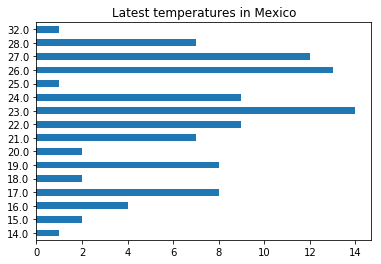

In [86]:
df.tempc.value_counts().sort_index(ascending = True).plot(kind = 'barh')
plt.title('Latest temperatures in Mexico')

In [100]:
ax = gdf.plot(column = 'tempc', colormap = 'viridis')
mpll.display(fig = ax.figure)



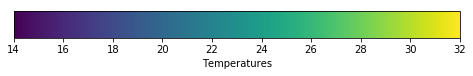

In [99]:
f, ax1 = plt.subplots(figsize = [8,0.5])
norm = mpl.colors.Normalize(df.tempc.min(), df.tempc.max())
cb1 = mpl.colorbar.ColorbarBase(ax1, norm = norm, cmap='viridis',
                                orientation='horizontal')
cb1.set_label('Temperatures')

#### 2. Further geospatial: bounding boxes, POIs from OSM, spatial joins

In [141]:
import osmnx as ox

ModuleNotFoundError: No module named 'osmnx'

In [136]:
my_geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -7.888183593749999,
              33.52193393882357
            ],
            [
              -7.845611572265626,
              33.44691195612031
            ],
            [
              -7.665023803710937,
              33.39647903888081
            ],
            [
              -7.5894927978515625,
              33.3081509817752
            ],
            [
              -7.481689453125,
              33.36437011569788
            ],
            [
              -7.47344970703125,
              33.4955977448657
            ],
            [
              -7.422637939453126,
              33.60546961227188
            ],
            [
              -7.327880859374999,
              33.716343950060214
            ],
            [
              -7.4054718017578125,
              33.76544869849223
            ],
            [
              -7.888183593749999,
              33.52193393882357
            ]
          ]
        ]
      }
    }
  ]
}

In [137]:
my_geojson

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-7.888183593749999, 33.52193393882357],
      [-7.845611572265626, 33.44691195612031],
      [-7.665023803710937, 33.39647903888081],
      [-7.5894927978515625, 33.3081509817752],
      [-7.481689453125, 33.36437011569788],
      [-7.47344970703125, 33.4955977448657],
      [-7.422637939453126, 33.60546961227188],
      [-7.327880859374999, 33.716343950060214],
      [-7.4054718017578125, 33.76544869849223],
      [-7.888183593749999, 33.52193393882357]]]}}]}

In [140]:
ax = gpd.GeoDataFrame.from_features(my_geojson).plot()
mpll.display(fig = ax.figure)

/Users/nicholasjones/anaconda3/envs/GPD/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


#### 3. Working with sample weights

The data below is from a Nigerian household survey for 2016 (called GHS-Panel 2016). 

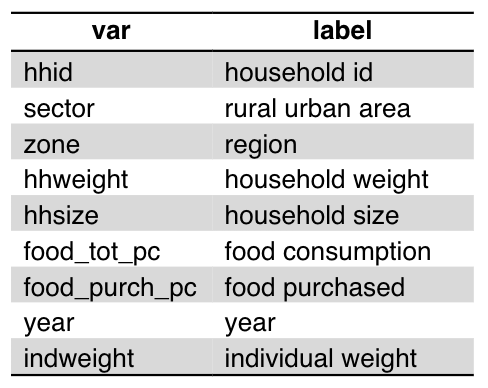

In [287]:
from IPython.display import Image
Image('data/nigeria_table.png', width = 250)

In [288]:
df2 = pd.read_csv('data/food2_pc.csv')

In [289]:
df2.head(2)

,hhid,sector,zone,hhweight,hhsize,food_tot_pc,food_purch_pc,year,indweight
0,10001,1. URBAN,4. SOUTH EAST,11898.656886,6,66134.52,66134.52,2016,71391.94
1,10002,1. URBAN,4. SOUTH EAST,11898.656886,5,154360.40,154360.40,2016,59493.29


In [290]:
df2.rename(columns = {'hhweight':'household_weight','hhsize':'household_size','food_tot_pc':'food_consumption_pc',
           'food_purch_pc':'food_purchased_pc','indweight':'individual_weight'}, inplace=True)

In [291]:
df2.sector.replace({'1. URBAN': 'urban', '2. RURAL':'rural'}, inplace=True)
df2.zone.replace({'1. URBAN': 'urban', '2. RURAL':'rural'}, inplace=True)

In [292]:
df2.zone.replace({'4. SOUTH EAST':'south_east', '2. NORTH EAST':'north_east', '5. SOUTH SOUTH':'south_south',
       '1. NORTH CENTRAL':'north_central', '6. SOUTH WEST':'south_west', '3. NORTH WEST':'north_west'}, inplace = True)

In [293]:
df2.columns

Index(['hhid', 'sector', 'zone', 'household_weight', 'household_size',
       'food_consumption_pc', 'food_purchased_pc', 'year',
       'individual_weight'],
      dtype='object')

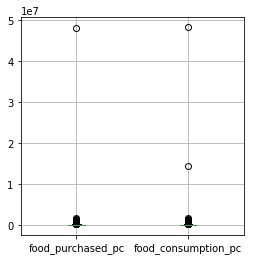

In [294]:
df2[['food_purchased_pc', 'food_consumption_pc']].boxplot(figsize = [4,4])

In [295]:
df2['food_purchased_pc'][df2['food_purchased_pc'] > (df2.food_purchased_pc.mean() + df2.food_purchased_pc.std() * 1)] = np.nan
df2['food_consumption_pc'][df2['food_consumption_pc'] > (df2.food_consumption_pc.mean() + df2.food_consumption_pc.std() * 1)] = np.nan
df2.dropna(inplace = True)

/Users/nicholasjones/anaconda3/envs/GPD/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/nicholasjones/anaconda3/envs/GPD/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [296]:
df2.columns

Index(['hhid', 'sector', 'zone', 'household_weight', 'household_size',
       'food_consumption_pc', 'food_purchased_pc', 'year',
       'individual_weight'],
      dtype='object')

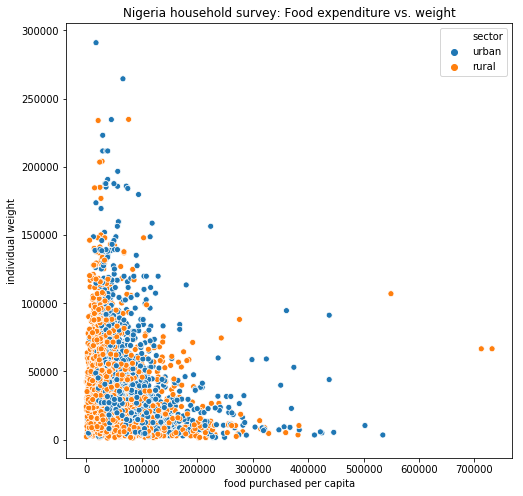

In [297]:
f, ax = plt.subplots(figsize = [8,8])
sns.scatterplot(x = 'food_purchased_pc', y = 'individual_weight', data = df2, hue = 'sector',ax = ax)
plt.xlabel('food purchased per capita')
plt.ylabel('individual weight')
plt.title('Nigeria household survey: Food expenditure vs. weight');

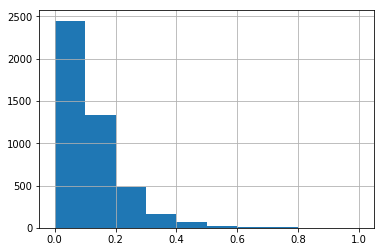

In [307]:
# Unclear what the indweight column represents, and how to apply the sample weights

# This applies a min-max scaling, to normalize the weights to the range 0-1

df2['normalized_weights'] = (df2.individual_weight - df2.individual_weight.min())/ (df2.individual_weight.max()-df2.individual_weight.min()) 
df2.normalized_weights.hist()


In [300]:
df2['food_purchased_pc_weighted'] = df2.food_purchased_pc * df2.normalized_weights

In [308]:
df2['food_purchased_pc'].groupby(df2.zone).median()

zone
north_central    37845.935
north_east       30503.570
north_west       30394.940
south_east       56879.200
south_south      67000.720
south_west       55095.710
Name: food_purchased_pc, dtype: float64

In [309]:
df2['food_purchased_pc_weighted'].groupby(df2.zone).median()

zone
north_central    2994.435714
north_east       2877.994145
north_west       4401.272073
south_east       3493.133842
south_south      5279.327720
south_west       5037.476674
Name: food_purchased_pc_weighted, dtype: float64

In [310]:
# set a threshold to determine whether an individual is in food poverty

poverty_threshold = df2.food_purchased_pc.quantile(0.25) # just setting it at the 25th percentile for convenience

In [311]:
df2['food_poverty_marker'] = df2.food_purchased_pc < poverty_threshold

Text(0.5, 1.0, 'Percent households in food poverty by geographic zone')

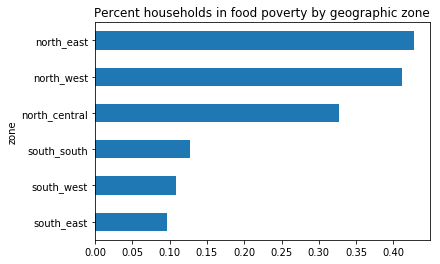

In [321]:
df2.food_poverty_marker.groupby(df2['zone']).mean().sort_values(ascending=True).plot(kind = 'barh')
plt.title('Percent households in food poverty by geographic zone')